In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Apr 22 14:40:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
print(tf.__version__)

2.8.0


# 1. Set up paths for all directories

In [4]:
import os

In [5]:
CUSTOM_MODEL_NAME = 'my_ssd_mobilnet_v2' 
LABEL_MAP_NAME = 'label_map.pbtxt'

In [6]:
paths = {
    'WORKSPACE_PATH': os.path.join('tfod', 'workspace'),
    'APIMODEL_PATH': os.path.join('tfod','models'),
    'ANNOTATION_PATH': os.path.join('tfod', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('tfod', 'workspace','images'),
    'MODEL_PATH': os.path.join('tfod', 'workspace','models'),
    'CHECKPOINT_PATH': os.path.join('tfod', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('tfod', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'PROTOC_PATH':os.path.join('tfod','protoc')
 }

In [7]:
files = {
    'PIPELINE_CONFIG':os.path.join('tfod', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [8]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# 2. Install tensorflow object detection API

In [ ]:
# https://www.tensorflow.org/install/source_windows

In [9]:
if os.name=='nt':
    !pip install wget
    import wget

In [10]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

Cloning into 'tfod/models'...
remote: Enumerating objects: 72064, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 72064 (delta 1), reused 7 (delta 1), pack-reused 72055
Receiving objects: 100% (72064/72064), 578.92 MiB | 39.02 MiB/s, done.
Resolving deltas: 100% (50960/50960), done.


In [11]:
!fc-list

/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Italic.ttf: Liberation Sans Narrow:style=Italic
/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf: Liberation Sans:style=Regular
/usr/share/fonts/truetype/liberation/LiberationMono-BoldItalic.ttf: Liberation Mono:style=Bold Italic
/usr/share/fonts/truetype/liberation/LiberationSerif-Italic.ttf: Liberation Serif:style=Italic
/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf: Liberation Mono:style=Bold
/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf: Liberation Sans Narrow:style=Regular
/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf: Liberation Serif:style=Bold
/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf: Liberation Mono:style=Regular
/usr/share/fonts/truetype/liberation/LiberationSans-Italic.ttf: Liberation Sans:style=Italic
/usr/share/fonts/truetype/liberation/LiberationSerif-BoldItalic.ttf: Liberation Serif:style=Bold Italic
/usr/share/fonts/truet

### Add the follwing if in Colab
#### May no longer needed when TFOD API upgraded to 2.8.0 in the future

'tensorflow==2.7.0',

'tf-models-official==2.7.0',

'tensorflow_io==0.23.1',

In [12]:
# Install Tensorflow Object Detection 
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd tfod/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd tfod/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd tfod/models/research/slim && pip install -e . 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
Processing /content/tfod/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 10.2 MB 8.1 MB/s 
     |████████████████████████████████| 352 kB 73.3 MB/s 
     |████████████████████████████████| 2.2 MB 51.8 MB/s 
     |████████████████████████████████| 23.4 MB 34.3 MB/s 
     |████████████████████████████████| 99 kB 12.6 MB/s 
     |████████████████████████████████| 90 kB

### Verify TFOD API is correctly installed

In [13]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

Running tests under Python 3.7.13: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
2022-04-22 14:46:57.029072: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
W0422 14:46:57.294085 140620478404480 model_builder.py:1102] Building experimental DeepMAC meta-arch. Some features may be omitted.
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_deepmac): 2.86s
I0422 14:46:57.657622 140620478404480 test_util.py:2374] time(__main__.ModelBuilderTF2Test.test_create_center_net_deepmac): 2.86s
[       OK ] ModelBuilderTF2Test.test_create_center_net_deepmac
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)): 0.5s
I0422 14:46:58.162479 140620478404480 test_

# 3. Create label map

In [14]:
labels = [{'name':'High 5', 'id':1}, {'name':'Point Up', 'id':2}, 
          {'name':'Point Down', 'id':3}, {'name':'Good', 'id':4},
          {'name':'Point Right', 'id':5}, {'name':'Point Left', 'id':6}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 4. Import images

In [15]:
print(paths['IMAGE_PATH'])

tfod/workspace/images


### Save archive.tar.gz to IMAGE_PATH, then execute the following

In [20]:
ARCHIVE_FILES = os.path.join(paths['IMAGE_PATH'], 'archive.tar.gz')
if os.path.exists(ARCHIVE_FILES):
  !tar -zxvf {ARCHIVE_FILES}

tfod/workspace/images/train/
tfod/workspace/images/train/Good_7.xml
tfod/workspace/images/train/Good_1.jpg
tfod/workspace/images/train/Good_1.xml
tfod/workspace/images/train/Good_2.jpg
tfod/workspace/images/train/Good_2.xml
tfod/workspace/images/train/Good_3.jpg
tfod/workspace/images/train/Good_3.xml
tfod/workspace/images/train/Good_4.jpg
tfod/workspace/images/train/Good_4.xml
tfod/workspace/images/train/Good_5.jpg
tfod/workspace/images/train/Good_5.xml
tfod/workspace/images/train/Good_6.jpg
tfod/workspace/images/train/Good_6.xml
tfod/workspace/images/train/Good_7.jpg
tfod/workspace/images/train/H5_5.xml
tfod/workspace/images/train/H5_1.jpg
tfod/workspace/images/train/H5_1.xml
tfod/workspace/images/train/H5_2.jpg
tfod/workspace/images/train/H5_2.xml
tfod/workspace/images/train/H5_3.jpg
tfod/workspace/images/train/H5_3.xml
tfod/workspace/images/train/H5_4.jpg
tfod/workspace/images/train/H5_4.xml
tfod/workspace/images/train/H5_5.jpg
tfod/workspace/images/train/PD_3.xml
tfod/workspace/ima

# 5. Load trained model

In [17]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [18]:
print(paths['MODEL_PATH'])

tfod/workspace/models


### Save models.tar.gz to MODEL_PATH, then execute the following

In [22]:
MODEL_FILES = os.path.join(paths['MODEL_PATH'], 'models.tar.gz')
if os.path.exists(MODEL_FILES):
  !tar -zxvf {MODEL_FILES}

tfod/workspace/models/my_ssd_mobilnet_v2/
tfod/workspace/models/my_ssd_mobilnet_v2/checkpoint
tfod/workspace/models/my_ssd_mobilnet_v2/tfjsexport/
tfod/workspace/models/my_ssd_mobilnet_v2/ckpt-3.index
tfod/workspace/models/my_ssd_mobilnet_v2/tfliteexport/
tfod/workspace/models/my_ssd_mobilnet_v2/ckpt-3.data-00000-of-00001
tfod/workspace/models/my_ssd_mobilnet_v2/ckpt-5.index
tfod/workspace/models/my_ssd_mobilnet_v2/ckpt-2.data-00000-of-00001
tfod/workspace/models/my_ssd_mobilnet_v2/ckpt-5.data-00000-of-00001
tfod/workspace/models/my_ssd_mobilnet_v2/ckpt-1.index
tfod/workspace/models/my_ssd_mobilnet_v2/ckpt-1.data-00000-of-00001
tfod/workspace/models/my_ssd_mobilnet_v2/ckpt-2.index
tfod/workspace/models/my_ssd_mobilnet_v2/train/
tfod/workspace/models/my_ssd_mobilnet_v2/train/events.out.tfevents.1650561386.1796aecf9f7e.620.0.v2
tfod/workspace/models/my_ssd_mobilnet_v2/pipeline.config
tfod/workspace/models/my_ssd_mobilnet_v2/ckpt-4.data-00000-of-00001
tfod/workspace/models/my_ssd_mobilnet

In [23]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-5')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 6. Detect from an Image

In [24]:
!pip install opencv-python-headless==4.1.2.30

     |████████████████████████████████| 21.8 MB 1.4 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.5.5.64
    Uninstalling opencv-python-headless-4.5.5.64:
      Successfully uninstalled opencv-python-headless-4.5.5.64


In [25]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [26]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [27]:
import glob

### Following code is used for testing images saved on hard drive
### Need to revise to test real-time images

coordiantes of y_min, x_min, y_max, x_max for each bounding box
[[ 42.95257   299.14484   502.14636   626.5659   ]
 [  6.9056582  24.893694  298.9952    198.40916  ]
 [  0.         11.7565565 281.32376   182.50714  ]
 [306.11896    25.46664   546.252     220.25644  ]
 [  9.966263    9.8608675 297.92844   182.14577  ]
 [  9.966263    9.8608675 297.92844   182.14577  ]
 [ 10.861616    0.        319.27655   225.63777  ]]

[{'name': 'High 5', 'id': 1}, {'name': 'Point Up', 'id': 2}, {'name': 'Point Down', 'id': 3}, {'name': 'Good', 'id': 4}, {'name': 'Point Right', 'id': 5}, {'name': 'Point Left', 'id': 6}]
[1 3 1 6 4 6 1]

prediction confidence of each bounding box, confidence <50 not shown
[0.9999291  0.07807913 0.06607813 0.04851533 0.03999903 0.03081731
 0.03064724]


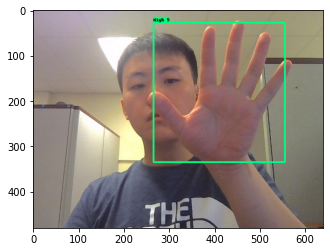

In [28]:
# Image resolution has to be 640 * 480

test_file_name = "H5_6"
img_path = os.path.join(paths['IMAGE_PATH'], 'test', '{}.jpg'.format(test_file_name))

img = cv2.imread(img_path)
image_np = np.array(img)
image_np_output = image_np.copy()

y_dim = 640
x_dim = 480
x_start = 0
y_start = 0

# image_np = image_np[y_start:y_start+y_dim,
#                   x_start:x_start+x_dim, :]

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
            for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)


label_id_offset = 1

image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=7,
            min_score_thresh=.6,
            agnostic_mode=False,
            skip_scores=True)

# image_np_output[:,560:,:] = image_np_with_detections

image_np_output = image_np_with_detections

# plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.imshow(cv2.cvtColor(image_np_output, cv2.COLOR_BGR2RGB))
save_path=os.path.join(paths['IMAGE_PATH'], 'annotated','{}.jpg'.format(test_file_name))
# plt.imsave(save_path,cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
# plt.imsave(save_path,cv2.cvtColor(image_np_output, cv2.COLOR_BGR2RGB))
detections_copy = detections.copy()
detections_copy['detection_boxes'][:,0]*=720
detections_copy['detection_boxes'][:,1]*=720
detections_copy['detection_boxes'][:,2]*=720
detections_copy['detection_boxes'][:,3]*=720
print('coordiantes of y_min, x_min, y_max, x_max for each bounding box')
print(detections_copy['detection_boxes'][:7])
print()
print(labels)
print(detections_copy['detection_classes'][:7]+label_id_offset)
print()
print('prediction confidence of each bounding box, confidence <50 not shown')
print(detections_copy['detection_scores'][:7])

plt.show()

In [29]:
files_img = [f for f in os.listdir(os.path.join(paths['IMAGE_PATH'], 'test')) if f[-3:]=='jpg']

In [30]:
print(files_img)

['PR_7.jpg', 'Good_9.jpg', 'PU_6.jpg', 'PL_4.jpg', 'PD_5.jpg', 'H5_8.jpg', 'H5_6.jpg', 'PR_9.jpg', 'PU_5.jpg', 'PD_4.jpg', 'H5_7.jpg', 'Good_8.jpg', 'PR_11.jpg', 'PL_5.jpg', 'Good_10.jpg', 'PR_8.jpg', 'Good_11.jpg', 'PR_10.jpg']


## LOOP

In [32]:
for f in files_img:
  test_file_name = f
  img_path = os.path.join(paths['IMAGE_PATH'], 'test', '{}'.format(test_file_name))

  img = cv2.imread(img_path)
  image_np = np.array(img)
  image_np_output = image_np.copy()

  y_dim = 640
  x_dim = 480
  x_start = 0
  y_start = 0

  # image_np = image_np[y_start:y_start+y_dim,
  #                   x_start:x_start+x_dim, :]

  input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
  detections = detect_fn(input_tensor)

  num_detections = int(detections.pop('num_detections'))
  detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
  detections['num_detections'] = num_detections

  # detection_classes should be ints.
  detections['detection_classes'] = detections['detection_classes'].astype(np.int64)


  label_id_offset = 1

  image_np_with_detections = image_np.copy()

  viz_utils.visualize_boxes_and_labels_on_image_array(
              image_np_with_detections,
              detections['detection_boxes'],
              detections['detection_classes']+label_id_offset,
              detections['detection_scores'],
              category_index,
              use_normalized_coordinates=True,
              max_boxes_to_draw=7,
              min_score_thresh=.6,
              agnostic_mode=False,
              skip_scores=True)

  # image_np_output[:,560:,:] = image_np_with_detections

  image_np_output = image_np_with_detections

  # plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
  plt.imshow(cv2.cvtColor(image_np_output, cv2.COLOR_BGR2RGB))
  save_path=os.path.join(paths['IMAGE_PATH'], 'annotated','{}.jpg'.format(test_file_name))
  plt.imsave(save_path,cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
  # plt.imsave(save_path,cv2.cvtColor(image_np_output, cv2.COLOR_BGR2RGB))
  detections_copy = detections.copy()
  detections_copy['detection_boxes'][:,0]*=720
  detections_copy['detection_boxes'][:,1]*=720
  detections_copy['detection_boxes'][:,2]*=720
  detections_copy['detection_boxes'][:,3]*=720
  print('coordiantes of y_min, x_min, y_max, x_max for each bounding box')
  print(detections_copy['detection_boxes'][:7])
  print()
  print(labels)
  print(detections_copy['detection_classes'][:7]+label_id_offset)
  print()
  print('prediction confidence of each bounding box, confidence <50 not shown')
  print(detections_copy['detection_scores'][:7])

  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [33]:
ANNOTATION_PATH = os.path.join('tfod', 'workspace', 'images', 'annotated')
ARCHIVE_PATH = os.path.join('tfod', 'workspace', 'images', 'annotations.tar.gz')

In [34]:
!tar -czf {ARCHIVE_PATH} {ANNOTATION_PATH}